In [57]:
import os
import sys
import math
from liblibra_core import * 
from libra_py import *
import numpy as np
import cProfile, pstats, io
import matplotlib.pyplot as plt
from scipy.special import gamma

print('done')

done


In [372]:
def profiler(func):
    # Decorater to profile the code, use for development
    def wrapper(*args, **kwargs):
        pr = cProfile.Profile()
        pr.enable()
        retval = func(*args, **kwargs)
        pr.disable()
        s = io.StringIO()
        sortby = 'cumulative'
        ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
        ps.print_stats()
        print(s.getvalue())
        return(retval)
    return(wrapper)

#@profiler
def MIW_Forces(X, params, P = 0, Rsq = 0, Pi = 0, dPijk = 0, ddPijk = 0, dPik = 0, ddPik = 0, gik = 0):
    """
    Args:
        X: Numpy array containing arrays of N world configurations. N x JD dimensions.
        params: Dictionary with simulation parameters
        OPTIONAL: Include matrices of correct shape for force computation *Avoids ~10 allocs per MD step*
    Returns:
        forces: Python list of the MIW forces, for addition to the classical ones in Nuclear object.f prior to propagation.
    """
    # D is dimensionality of space, J is number of particles per world, N is number of worlds.
    # b is kernel width parameter, and ktype is the type of kernel (exp or gaussian for now)
    # M is the matrix of size X.shape containing masses for the particles at the relevant entry M[i][k]
    # Notation in all functions consistent with 10.1103/PhysRevE.97.053311 and 10.1103/PhysRevX.4.041013
    N = len(X) 
    b = params["b"]
    D = params["D"]
    J = params["J"]
    M = params["M"]
    ktype = params["ktype"]
    
    if type(P) == int:
        # Initializes all needed multidims with correct shape
        # i/j loop over worlds i.e 1->N in conventional sense
        # k loops over coords i.e. 1->J*D in conventional sense
        Rsq   = np.zeros( (N, N) )
        P     = np.zeros( (N, N) )
        F     = np.zeros( (N, J*D) )
        Pi    = np.zeros( (N) )
        dPijk = np.zeros( (N, N, J*D) )
        dPik  = np.zeros( (N, J*D) )
        ddPijk= np.zeros( (N, N, J*D) )
        ddPik = np.zeros( (N, J*D) )
        gik   = np.zeros( (N, J*D) )

        
    #Compute Rsq matrix
    Rsq = Compute_Rsquared(X, Rsq)

    #Populate P matrix for P[i][j]
    P = Compute_P(X, Rsq, ktype, b, D, P = P)

    #Populate Pi matrix for Pi[i]
    for i in range(N):
        Pi[i] = Compute_Pi(X, P, i)


    #3 index terms computed together to minimize python looping
    #Populate dPijk matrix for dPijk[i][j][k]
    #Populate ddPijk matrix for ddPijk[i][j][k]
    for i in range(N):
        for k in range(J*D):
            for j in range(N):
                dPijk[i][j][k]  = Compute_dPijk(X, Rsq, i, j, k, b, P, ktype)
                ddPijk[i][j][k] = Compute_ddPijk(X, Rsq, i, j, k, b, P, ktype)

                #2 index terms computed in this same loop to minimize python loops further
                #Populate dPik matrix for dPik[i][k]
                #Populate ddPik matrix for ddPik[i][k]
                if j == range(N)[-1]:
                    #Works because for given i, k, once last j is filled out, 
                    #Pijk holds all j values for a given i, k
                    dPik[i][k]  = Compute_dPik(X, i, k, b, dPijk, ktype)
                    ddPik[i][k] = Compute_ddPik(X, i, k, b, ddPijk, ktype)
                    gik[i][k]   = Compute_gik(X, i, k, b, dPik, Pi, ktype) 
    
    if ktype.lower() == "gaussian":         
        # 1D has significantly easier computation.
        if D == 1:
            # print("Using simplified forces for D = 1")
            for n in range(N):
                for l in range(J*D):
                    F[n][l] = -1 * ( ( 2 * gik[n][l] * ( -( 1.0/(Pi[n]**2) ) * dPik[n][l]**2 + ( 1.0/Pi[n] ) * ddPik[n][l] ) ) )

                    for i in range(N):
                        if i != n:
                            F[n][l] += -1 * 2 * gik[i][l] * ( ( 1.0/(Pi[i]**2) ) * dPijk[i][n][l]*dPik[i][l] 
                                                       - ( 1.0/Pi[i] ) * ddPijk[i][n][l] )
        # General case for D != 1                    
        else:
            for n in range(N):
                for l in range(J*D):
                    F[n][l] = -1 * ( ( 2 * gik[n][l] * ( -( 1.0/(Pi[n]**2) ) * dPik[n][l]**2 + ( 1.0/Pi[n] ) * ddPik[n][l] ) ) )

                    for i in range(N):
                        if i != n:
                            F[n][l] += -1 * 2 * gik[i][l] * ( ( 1.0/(Pi[i]**2) ) * dPijk[i][n][l]*dPik[i][l] 
                                                       - ( 1.0/Pi[i] ) * ddPijk[i][n][l] )
                    for k in range(J*D):
                        if k != l:
                            res = 0
                            for j in range(N):
                                res += ( X[n][k]-X[j][k] ) * dPijk[n][j][l]

                            F[n][l] += -1 * 2 * gik[n][k] * ( -( 1.0/(Pi[n]**2) ) * dPik[n][k]*dPik[n][l] 
                                                            - 2.0/( b**2 * Pi[n] ) * res ) 

                    for i in range(N):
                        if i != n:
                            for k in range(J*D):
                                if k != l:
                                    F[n][l] += -1 * 2 * gik[i][k] * ( ( 1.0/(Pi[i]**2) ) * dPijk[i][n][k] * dPik[i][l]
                                                                    + ( 2.0/(b**2 * Pi[i]) ) * ( X[i][k] - X[n][k] ) * dPijk[i][n][l] )    
    elif ktype.lower() == "exponential": 
        for n in range(N):
            for l in range(J*D):
                #Compute dU/dx_n^l
                F[n][l] += -1 * 2*gik[n][l]*( - ( 1/Pi[n]**2 ) * dPik[n][l]**2 + (1/Pi[n]) * ddPik[n][l] )
                
                for i in range(N):
                    if i != n:
                        F[n][l] += -1 * 2*gik[i][l]*( ( 1/Pi[i]**2 ) * dPijk[i][n][l] * dPik[i][l] - ( 1/Pi[i] ) * ddPijk[i][n][l] )
                for k in range(J*D):
                    if k != l:
                        res = 0
                        for j in range(N):
                            res += ( ( X[n][k]-X[j][k] ) / np.sqrt(Rsq[n][j]) ) * ( ( 1.0/np.sqrt(Rsq[n][j]) ) + ( 1.0/b ) ) * dPijk[n][j][l]             
                                                                         
                        F[n][l] += -1 * 2*gik[n][k]*( -( 1/Pi[n]**2 )  * dPik[n][k] * dPik[n][l] - ( 1/Pi[n] ) * res )
                for i in range(N):
                    if i != n:
                        for k in range(J*D):
                            if k != l:
                                F[n][l] += -1 * 2*gik[i][k]*( ( 1/Pi[i]**2 ) * dPijk[i][n][k] * dPik[i][l] + ( 1/Pi[i] ) * ( ( X[i][k]-X[n][k] )/np.sqrt(Rsq[i][n]) ) * ( ( 1/np.sqrt(Rsq[i][n]) ) + ( 1/b ) ) * dPijk[i][n][l] )
    
    U = Compute_MIW_Potential(X, b, gik, M, ktype)                                                    
    return(F, U)

def Compute_Rsquared(X, Rsq = 0):
    """
    Args:
        X: Numpy array containing arrays of N world configurations. N x JD dimensions.
        OPTIONAL Rsquared: Pass the last step's Rsquared matrix to avoid allocation cost at every step.
    Returns:
        Rsq: Matrix containing elements r_ij^2. Sum of squared distances of all componenents in the two worlds.
    """
    if type(Rsq) == int:
        Rsq = np.zeros((len(X), len(X)))
    else:
        pass
    
    for i in range(len(Rsq)):
        for j in range(len(Rsq[0])):
            Rsq[i][j] = np.inner(X[i]-X[j], X[i]-X[j])
    return(Rsq)

def  Compute_P(X, Rsq, ktype, b, D, P = 0):
    """
    Args:
        X: Numpy array containing arrays of N world configurations. N x JD dimensions.
        Rsq: Matrix containing elements r_ij^2. Sum of squared distances of all componenents in the two worlds.
        OPTIONAL, P: Passes P from last step to avoid reallocations at every dynamics step.
        ktype: Type of kernel being used, exponential or gaussian
    Returns:
        Rsq: Matrix containing elements r_ij^2. Sum of squared distances of all componenents in the two worlds.
    """
    if type(P) == int:
        P = np.zeros((len(X), len(X)))

    if ktype.lower() == 'gaussian':    
        for i in range(len(P)):
            for j in range(len(P)):
                P[i][j] = Compute_Pij(X, i, j, Rsq, b, D, ktype)
                
    # This is unnecessary since ktype is passed, but I'm just leaving it in for now
    # in case I separated these for some reason not immediately clear.
    elif ktype.lower() == 'exponential':
        for i in range(len(P)):
            for j in range(len(P)):
                P[i][j] = Compute_Pij(X, i, j, Rsq, b, D, ktype)
                
    
    return(P)
    
    
def Compute_Pij(X, i, j, Rsq, b, D, ktype):
    """
    Args:
        X: Numpy array containing arrays of N world configurations. N x JD dimensions.
        i: Index of the world being computed for
        j: Index to be summed over in computation of P_i
        b: Kernel width parameter
        D: Dimensionality of the space (used in cofactors)
        ktype: Kernel type ("gaussian" or "exponential")
        rijsquared: Sum of squared distances between coords of worlds i, j, $r_{ij}^2 = \Sigma_{k}( r_{ij}^k )^2$
    Returns:
        Pij: Density contribution of particle j at the position of particle i (Used for forces)
    """
    N = len(X)
    # Gaussian Kernel Computation
    
    if ktype.lower() == "gaussian":
        return ( 1 / ( N * ( np.sqrt(np.pi) * b )**D )  ) * np.exp( - Rsq[i][j] / (b**2) )
    elif ktype.lower() == "exponential":
        return ( ( gamma(D/2) / ( 2*N * math.factorial(D-1) * (np.sqrt(np.pi) * b )**D )  ) * np.exp(- np.sqrt(Rsq[i][j]) / b )  )
    

    
def Compute_Pi(X, P, i):
    """
    Args:
        X: Numpy array containing arrays of N world configurations. N x JD dimensions.
        P: Promputed matrix with elements computed by Compute_Pij() function. P[i][j] = Compute_Pij(X, i, j, ...)
        i: Index of the world being computed for
    Returns:
        Pi: $\Sigma_{j} P_{ij}$
    """
    N = len(X)
    res = 0
    
    for j in range(N):
        res+= P[i][j]
        
    return(res)
        
        
def Compute_dPijk(X, Rsq, i, j, k, b, P,  ktype):
    """
    Args:
        X: Numpy array containing arrays of N world configurations. N x JD dimensions.
        Rsq: Matrix with Rsq[i][j] standard inner product of (X[i][j], X[i][j])
        i: Index of the world being computed for
        j: Index to be summed over in computation of dP_i
        b: Kernel width parameter
        P: Matrix with elements Pij. Precomputed due to their usage in all derivatives.
        ktype: Kernel type ("gaussian" or "exponential")
        Pij: Value for Pij precomputed and stored in the P matrix. Pij = P[i][j]
    """
    
    rij_k = (X[i][k] - X[j][k])
    
    if ktype.lower() == "gaussian":
        return( -(2.0/b**2) * rij_k * P[i][j] )
    elif ktype.lower() == "exponential":
        if i != j:
            return (  -1/b * ( rij_k / np.sqrt(Rsq[i][j]) ) * P[i][j]  ) 
        else:
            return ( 0.0 ) 
    else:
        return("Error, kernel type not yet implemented.")
    
# Remove ktype later
def Compute_dPik(X, i, k, b, dPijk, ktype):
    """
    Args:
        X: Numpy array containing arrays of N world configurations. N x JD dimensions.
        i: Index of the world being computed for
        k: Component within the worlds being computed for.
        b: Kernel width parameter
        P: Matrix with elements Pij. Precomputed due to their usage in all derivatives.
        ktype: Kernel type ("gaussian" or "exponential") 
    Returns:
        res: dP_i^k, Sum over worlds j, of dPijk. Needed for force computation.
    """
    res = 0
    for j in range(len(X)):      
        res += dPijk[i][j][k]

    return(res)

def Compute_ddPijk(X, Rsq, i, j, k, b, P, ktype):
    """
    Args:
        X: Numpy array containing arrays of N world configurations. N x JD dimensions.
        Rsq: Matrix with Rsq[i][j] standard inner product of (X[i][j], X[i][j])
        i: Index of the world being computed for
        j: Index to be summed over in ddP_i
        k: Component within the worlds being computed for.
        b: Kernel width parameter
        P: Matrix with elements Pij. Precomputed due to their usage in all derivatives.
        ktype: Kernel type ("gaussian" or "exponential")
    Returns:
        res: ddP_ij^k. Needed for force computations.
    """
    rij_k = X[i][k] - X[j][k]
    
    if ktype.lower() == "gaussian":
        # Test line
        # return( -2.0/(b**2) * ( 1 - (2.0/(b**2)) * np.sqrt(Rsq[i][j]) ) * P[i][j] )
        
        return( -2.0/(b**2) * ( 1 - (2.0/(b**2)) * rij_k**2 ) * P[i][j] )
        
    elif ktype.lower() == "exponential":
        if i != j:
            return( -1/(np.sqrt(Rsq[i][j]) * b) * ( 1.0 - (rij_k**2)/Rsq[i][j] - (1.0/b) * (rij_k**2)/np.sqrt(Rsq[i][j]) ) * P[i][j] ) 
        else:
            return ( 0 )

#Remove ktype later
def Compute_ddPik(X, i, k, b, ddPijk, ktype):
    res = 0
    for j in range(len(X)):
        res += ddPijk[i][j][k]
    
    return(res)
    
def Compute_gik(X, i, k, b, dPik, Pi, ktype):
    """
    Args:
        X: Numpy array containing arrays of N world configurations. N x JD dimensions.
        i: Index of the world being computed for
        k: Component within the worlds being computed for.
        b: Kernel width parameter
        dPik: Matrix with dPik[i][k] elements for gik[i][k] computation
        Pi: Matrix with Pi[i] elements for gik[i][k] computation
        ktype: Kernel type ("gaussian" or "exponential")
    Returns:
        gik[i][k] value needed for computation of MIW forces and potential
    """
    return( .5 * dPik[i][k] / Pi[i] )

# For use in force computation funciton
def Compute_MIW_Potential(X, b, gik, M, ktype):
    """
    Args:
        X: Numpy array containing arrays of N world configurations. N x JD dimensions.
        b: Kernel width parameter
        gik: Matrix containing gik elements as gik[i][k] **If not passed, will be computed using X.
        Mik: Matrix containing mass for the particle corresponding to X[i][k] as Mik[i][k]
        ktype: Kernel type ("gaussian" or "exponential")
    Returns:
        U: Scalar potential for the MIW potential U(X) ***Same as Compute_MIW_Potential2***
    """
    res = 0
    for i in range(len(X)):
        for k in range(len(X[0])):
            res += .5 * 1/M[i][k] * gik[i][k] ** 2
    return(res)


# For use outside of force computation function:
def Compute_MIW_Potential2(X, params):
    """
    Args:
        X: Numpy array containing arrays of N world configurations. N x JD dimensions.
        params: Dictionary with simulation parameters
    Returns:
        U: Scalar potential for the MIW potential U(X) ***Same as Compute_MIW_Potential***
    """
    N = len(X) 
    b = params["b"]
    D = params["D"]
    J = params["J"]
    M = params["M"]
    ktype = params["ktype"]

    # Initializes all needed multidims with correct shape
    # i/j loop over worlds i.e 1->N in conventional sense
    # k loops over coords i.e. 1->J*D in conventional sense
    Rsq   = np.zeros( (N, N) )
    P     = np.zeros( (N, N) )
    F     = np.zeros( (N, J*D) )
    Pi    = np.zeros( (N) )
    dPijk = np.zeros( (N, N, J*D) )
    dPik  = np.zeros( (N, J*D) )
    ddPijk= np.zeros( (N, N, J*D) )
    ddPik = np.zeros( (N, J*D) )
    gik   = np.zeros( (N, J*D) )

        
    #Compute Rsq matrix
    Rsq = Compute_Rsquared(X, Rsq)

    #Populate P matrix for P[i][j]
    P = Compute_P(X, Rsq, ktype, b, D, P=P)

    #Populate Pi matrix for Pi[i]
    for i in range(N):
        Pi[i] = Compute_Pi(X, P, i)
    for i in range(N):
        for k in range(J*D):
            for j in range(N):
                dPijk[i][j][k]  = Compute_dPijk(X, Rsq, i, j, k, b, P, ktype)
                ddPijk[i][j][k] = Compute_ddPijk(X, Rsq, i, j, k, b, P, ktype)

                #2 index terms computed in this same loop to minimize python loops further
                #Populate dPik matrix for dPik[i][k]
                #Populate ddPik matrix for ddPik[i][k]
                if j == range(N)[-1]:
                    #Works because for given i, k, once last j is filled out, 
                    #Pijk holds all j values for a given i, k
                    dPik[i][k]  = Compute_dPik(X, i, k, b, dPijk, ktype)
                    ddPik[i][k] = Compute_ddPik(X, i, k, b, ddPijk, ktype)
                    gik[i][k]   = Compute_gik(X, i, k, b, dPik, Pi, ktype)
    res = 0
    for i in range(len(X)):
        for k in range(len(X[0])):
            res += .5 * 1/M[i][k] * gik[i][k] ** 2
    return(res)

        
def Populate1DUniform(N, spacing):
    X = np.zeros((N, 1))
    for i in range(N):
        X[i][0] = -(N-1)/2.0 * spacing + i*spacing
    return(X)

def Populate3DRandom(N, particles, boxmax):
    """
    Args:
        N: Number of worlds
        particles: Number of particles per work
        boxmax: max distance from origin along all dimensions for uniform sampling
    Returns:
        X: Uniformly sampled from [-boxmax, boxmax] in all 3 dimensions.
    """
    X = np.random.rand(N, 3*particles)
    X -= .5
    X *= boxmax*2
    return(X)


def Write_Frame_To_XYZ(X, D, filename):
    """
    Args:
        X: World configurations
        D: Dimensionality of the space (1,2,3 should work)
        filename: Desired output file name
    Returns:
        Nothing, modifies "filename" by adding the current world configuration to it in .xyz format
        ***Currently just uses a dummy atom X, will be changed to determine based off M matrix in future.
    """
    array = []
    if D == 1:
        for i in X:
            array.append([i[0], 0, 0])
    
        f = open(filename, "a")
        f.write(str(len(X)) + "\n")
        f.write("blank \n")
        for i in array:
            f.write("H" + "    " + str(i[0]) + "    " + str(i[1]) + "    " + str(i[2]) + "\n")
        f.close()
        
    if D == 2:
        for i in X:
            array.append([i[0], i[1], 0])
    
        f = open(filename, "a")
        f.write(str(len(X)) + "\n")
        f.write("blank \n")
        for i in array:
            f.write("H" + "    " + str(i[0]) + "    " + str(i[1]) + "    " + str(i[2]) + "\n")
        f.close()
        
    if D == 3:
        for i in X:
            array.append([i[0], i[1], i[2]])
    
        f = open(filename, "a")
        f.write(str(len(X)) + "\n")
        f.write("blank \n")
        for i in array:
            f.write("H" + "    " + str(i[0]) + "    " + str(i[1]) + "    " + str(i[2]) + "\n")
        f.close()
    return()

#Don't pass filename if you don't want to write to a file
def verlet(X, V, params, dt, steps, filename = 0, method = 0):
    if method == 0:
        F, U = MIW_Forces(X, params)
        for i in range(steps):
            X = X + V * dt + .5 * np.divide(F, M) * dt * dt
            V = V + .5 * np.divide(F, M) * dt
            F, U = MIW_Forces(X, params)
            V = V + .5 * np.divide(F, M) * dt

            if type(filename) != int:
                Write_Frame_To_XYZ(X, 1, filename)
        
    return()

def FiniteDiff(X, params, dx):                    
    Ucurr = Compute_MIW_Potential2(X, params)
    F = np.zeros( X.shape )
    for i1 in range(N):
        for i2 in range(J*D):
            Xtemp = X.copy()
            Xtemp[i1][i2] += dx                        
            Utemp = Compute_MIW_Potential2(Xtemp, params)
            F[i1][i2] = - (Utemp - Ucurr) / dx
            
    return(F)

def UnitConversions(inp, out, value):
    """
    Args:
        inp: String containing units of "value" as input
        out: String containing desired units for "value" as output
        value: Numerical value in units [inp] for conversion to [out]
    Returns:
        value in units [out]
    """
    #Masses
    if inp.lower() == "amu":
        if out == "au":
            return(value*1836.0)
    elif inp.lower() == "au":
        if out == "amu":
            return(value/1836.0)
    else:
        print("Units not supported")

def InitializeMM(X, params, atomlist = "H"):
    """
    Args:
        X: MIW configuration as numpy array
        atomlist: List of atomic types corresponding to entries of X
        params: Not sure what yet
    Returns:
        Xmm: Returns the N worlds, but as Libra objects containing info such as masses/positions/etc. 
    """
    #Set up now only for D = 3
    D = params["D"]
    
    FOLDERNAME = "tempsys"
    PREFIX = "world_"
    N = len(X)
    
    # Write X to xyz files by world to set up the libra objects.
    if atomlist == "H":
        os.system("rm -r %s" % FOLDERNAME)
        os.system("mkdir %s" % FOLDERNAME)
        
        for i in range(N):
            filename = PREFIX + str(i) + ".xyz"
            f = open(FOLDERNAME+"/"+filename, "w+")
            f.write(str(int(len(X[0])/D)) + "\n")
            f.write("\n")
            
            for j in range(int(len(X[0])/D)):
                f.write("H" + "    " + str(X[i][j*3]) + "    " + str(X[i][j*3 + 1]) + "    " + str(X[i][j*3] + 2) + "\n")

            f.close()
    else:
        return("Not yet implemented")
    
    
    #Populate Xmm, the list of libra objects containing the worlds for force computations.
    # I.e. Xmm = [world1, world2, ... , worldN] (indexed from 0)
    
    # Begin by setting up some libra objects.
    
    # Imports relevant chemical data. Must have elements.dat in wd.
    U = Universe()
    verbose = 0
    LoadPT.Load_PT(U, "elements.dat", verbose)
    
    # Set up the FF interactions. Simply LJ for now to test if it works.
    # Not working
    # uff = ForceField({"bond_functional":"Harmonic","vdw_functional":"LJ", "R_vdw_on":6.0, "R_vdw_off":7.0, "angle_functional":"Fourier"})
    uff = ForceField({"mb_functional":"LJ_Coulomb","R_vdw_on":0.0,"R_vdw_off":10.0 })
    LoadUFF.Load_UFF(uff)
    verb = 0
    assign_rings = 0
    
    
    
    for i in range(N):
        syst = System()
        workingFile = FOLDERNAME +"/" +  PREFIX + str(i) + ".xyz"
        print("Grabbing coordinates for world", i, "from", workingFile)
        LoadMolecule.Load_Molecule(U, syst, workingFile, "xyz");
        
        print(str(syst.show_info()))
        
        atlst1 = list(range(1,syst.Number_of_atoms+1))
        
        ham = Hamiltonian_Atomistic(1, 3*syst.Number_of_atoms)
        
        ham.set_Hamiltonian_type("MM")
        ham.set_interactions_for_atoms(syst, atlst1, atlst1, uff, verb, assign_rings)
        ham.set_system(syst)
        ham.compute()
        
        el = Electronic(1,0)
        mol = Nuclear(3*syst.Number_of_atoms)
        syst.extract_atomic_q(mol.q)        
        syst.extract_atomic_mass(mol.mass)
        
        
        print("mol.f[0]", mol.f[0])
        compute_forces(mol, el, ham, 1)
        print("mol.f[0]", mol.f[0])
        mol.q[0] = 500
        compute_forces(mol, el, ham, 1)
        print("mol.f[0]", mol.f[0])
        
        
#         print(mol.q[1])
#         mol.q[1] = 10
#         syst.set_atomic_q(mol.q)
#         print(mol.q[1])
        
        
#         ham.set_system(syst)
#         ham.compute()
        
#         print("Energy = ", ham.H(0,0), " a.u.")
#         print("Force 1 = ", ham.dHdq(0,0,0), " a.u.")
        
        # Not so sure if this is really needed, will test later.

#         syst.extract_atomic_f(mol.f)
#         syst.extract_atomic_p(mol.p)
        
        return(mol)

## Sets up system for testing simple 1D, 1 particle per world things (GAUSSIAN).

In [374]:
X = Populate3DRandom(10, 10, 5)
#print(X)
params = {"D":3}
mol = InitializeMM(X, params)

# for i in range(15):
#     if i % 3 == 0:
#         print("atom = ", i/3, ": ", mol.q[i]/1.88973)
#         print(mol.f[i])

Grabbing coordinates for world 0 from tempsys/world_0.xyz
12
None
mol.f[0] 0.0
mol.f[0] -0.002392385075332085
mol.f[0] 3.754254073963936e-67


In [4]:
N = 10
J = 1
D = 1
b = .5
spacing = .9

# Populate a simple uniform distirbution centered on origin for J = D = 1
# Populate the masses with simply all Mij = 1
X = Populate1DUniform(N, spacing)
M = np.zeros( X.shape )
M += 1.0
V = np.zeros( X.shape )

params = {
    "J":J,
    "D":D,
    "b":b,
    "ktype":"gaussian",
    "M":M,
}


F, U = MIW_Forces(X, params)



dx = 5e-8
Fdiff = FiniteDiff(X, params, dx)
print("GAUSSIAN Kernel:")
print("X positions\n", X, "\n")
print("Analytic Forces\n", F, "\n")
print("Finite diff Forces\n", Fdiff, "\n")


print("Checking that the two functions computing U(X) return the same thing:")
print("Compute1: ", U)
print("Compute 2: ", Compute_MIW_Potential2(X, params), "\n")

dt = .2
steps = 100
filename = "traj.xyz"
os.system("rm %s" % filename)
verlet(X, V, params, dt, steps, filename)

GAUSSIAN Kernel:
X positions
 [[-4.05]
 [-3.15]
 [-2.25]
 [-1.35]
 [-0.45]
 [ 0.45]
 [ 1.35]
 [ 2.25]
 [ 3.15]
 [ 4.05]] 

Analytic Forces
 [[ 1.66077421e+00]
 [ 4.28539027e-01]
 [ 1.70105276e-04]
 [ 1.36967070e-08]
 [ 4.61100530e-15]
 [-5.67549068e-15]
 [-1.36967029e-08]
 [-1.70105276e-04]
 [-4.28539027e-01]
 [-1.66077421e+00]] 

Finite diff Forces
 [[-1.07119060e-01]
 [ 1.07076383e-01]
 [ 4.24311281e-05]
 [-9.16627885e-08]
 [-9.51322354e-08]
 [-9.51322354e-08]
 [-9.85322934e-08]
 [-4.26213925e-05]
 [-1.07076594e-01]
 [ 1.07118975e-01]] 

Checking that the two functions computing U(X) return the same thing:
Compute1:  0.01841242733915679
Compute 2:  0.01841242733915679 



()

## Testing for same params as above (EXPONENTIAL).

In [5]:
N = 10
J = 1
D = 1
b = .5
# spacing = .51349
spacing = .9

# Populate a simple uniform distirbution centered on origin for J = D = 1
# Populate the masses with simply all Mij = 1
X = Populate1DUniform(N, spacing)
M = np.zeros( X.shape )
M += 1.0
V = np.zeros( X.shape )

params = {
    "J":J,
    "D":D,
    "b":b,
    "ktype":"exponential",
    "M":M,
}

print("EXPONENTIAL Kernel:")
print("X positions\n", X, "\n")
F, U = MIW_Forces(X, params)



dx = 5e-8
Fdiff = FiniteDiff(X, params, dx)
print("Analytic Forces\n", F, "\n")
print("Finite diff Forces\n", Fdiff, "\n")

print("Checking that the two functions computing U(X) return the same thing:")
print("Compute1: ", U)
print("Compute 2: ", Compute_MIW_Potential2(X, params), "\n")

dt = .2
steps = 100
filename = "traj.xyz"
os.system("rm %s" % filename)
verlet(X, V, params, dt, steps, filename)

EXPONENTIAL Kernel:
X positions
 [[-4.05]
 [-3.15]
 [-2.25]
 [-1.35]
 [-0.45]
 [ 0.45]
 [ 1.35]
 [ 2.25]
 [ 3.15]
 [ 4.05]] 

Analytic Forces
 [[-0.15797776]
 [ 0.10503039]
 [ 0.03976778]
 [ 0.01015866]
 [ 0.00182129]
 [-0.00182129]
 [-0.01015866]
 [-0.03976778]
 [-0.10503039]
 [ 0.15797776]] 

Finite diff Forces
 [[-0.03949444]
 [ 0.02625759]
 [ 0.00994193]
 [ 0.00253965]
 [ 0.00045531]
 [-0.00045533]
 [-0.00253968]
 [-0.00994196]
 [-0.02625761]
 [ 0.03949443]] 

Checking that the two functions computing U(X) return the same thing:
Compute1:  0.027915785280940415
Compute 2:  0.027915785280940415 



()

# Generating the Potential as a function of x1-x2

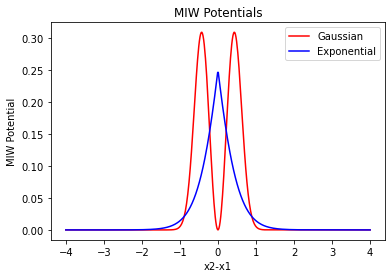

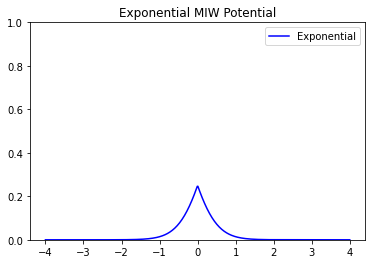

In [40]:
x1 = 0
start = -4
steps = 500
x2 = np.linspace(-start, start, steps)

b = .5

params = {
    "J":J,
    "D":D,
    "b":b,
    "ktype":"gaussian",
    "M":M,
}


X = np.zeros( ( 2 , 1 ) )

X[0][0] = x1
GaussianPotentials = np.zeros( (len(x2), 1) )
ExponentialPotentials = np.zeros( (len(x2), 1) )
for i in range(len(x2)):
    X[1][0] = x2[i]
    params["ktype"]="gaussian"
    F, U = MIW_Forces(X, params)
    GaussianPotentials[i] = U
    params["ktype"]="exponential"
    F, U = MIW_Forces(X, params)
    ExponentialPotentials[i] = U

plt.figure(1)
plt.title("MIW Potentials")
plt.xlabel("x2-x1")
plt.ylabel("MIW Potential")
plt.plot(x2, GaussianPotentials, color = 'red', label = 'Gaussian')
plt.plot(x2, ExponentialPotentials, color ='blue', label = 'Exponential')
plt.legend()


plt.figure(2)
plt.title("Exponential MIW Potential")
plt.plot(x2, ExponentialPotentials, color = 'blue', label = 'Exponential')
#plt.ylim((0, max(ExponentialPotentials)))
plt.ylim( ( 0, 1 ) ) 
plt.legend()

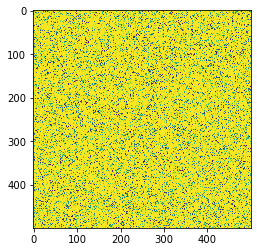

In [234]:
list(range(0,5))

arr = np.random.rand(500, 500)
for i in range(500):
    for j in range(500):
        arr[i][j] = np.exp(-arr[i][j]**10)
plt.imshow(arr, cmap='viridis', interpolation='nearest')